In [54]:
# load dependencies'
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn' surpresses warnings at spatial distribution
import geopandas as gpd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import numpy as np
import datetime
import plotly.express as px
import plotly.graph_objects as go

from envirocar import TrackAPI, DownloadClient, BboxSelector, ECConfig

# pandas show all columns of table instead of restricted
pd.set_option('display.max_columns', None)

# create an initial but optional config and an api client
config = ECConfig()
track_api = TrackAPI(api_client=DownloadClient(config=config))



# ------------------------ Functions --------------------------



def show_units(df):
    '''
        Aim: get an overview of the variables and corresponding units
        
        Keyword Arguments: 
            df {Geodataframe} -- point input
        
        Output: Matrix-like overview on variables an the relevant unit
    '''
    units = df.filter(like='.unit').columns
    for unit in units:
        if unit in df:
            print(df[unit].name, df[unit].iloc[0])
            

            
        
def visualize_normality_with_qqplot(point_df, column):
    '''
        Aim: create q-q plot to inspect normality of distribution of selected variable
        
    Keyword Arguments: 
        df {Geodataframe} -- points input
        column {str} -- variable name
        
        Output: Q-Q plot
    '''
    plot = stats.probplot(point_df[column],  dist="norm", plot=plt, fit = False)
    plt.title(column)
    plt.show()
    
    
    
    
def plot_tracks(points_df, column):
    """ 
    Aim: 
        Visualize phenomena of tracks as timeserie in Linechart, in which each line represents one single track
    
    Keyword Arguments: 
        df {Geodataframe} -- point input
        
    Returns:
        Chart is shown 
    
    """
    # Add datetime to data frame
    points_df['datetime'] = pd.to_datetime(points_df['time'])
    points_df.set_index(['track.id','datetime']).sort_index()
    points_df['index']=points_df.index
    fig = px.line(track_df, x="index", y=column, color="track.id",
                  line_group="track.id", hover_name="datetime")
    fig.update_traces(mode='lines+markers')
    fig.show()

    
    
def plot_distribution_s(points_df, column, column_gps = None):
    """ 
    Aim:
        Plot of two distributions in a single figure for visually comparing the shapes of the two distributions
    
    Keyword Arguments: 
        points {GeoDataFrame} -- the GeoDataFrame containing the measurements
        Column {str} -- the column name of measurement of interest,e.g. 'Speed.value'
        Column {str} -- the column name of measurement of same phenomena but measured based on GPS, e.g. 'GPS speed.value'
        
    Return:
        No Return, instead a plot is displayed
    """
    if column_gps is not None:
        sns.kdeplot(points_df[column], shade=True)
        sns.kdeplot(points_df[column_gps], shade=True)
    else:
        sns.kdeplot(points_df[column], shade=True)
    


def plot_point_values(points, value = None):
        """ This function is based on a function from the envirocar fork of the github user 'annaformaniuk'.
        
        Aim: show points on a map

        Keyword Arguments:
            points {GeoDataFrame} -- points input
            value {string} -- column value to use for colouriing

        Returns:
            No Return
        """

        points['lat'] = points['geometry'].apply(lambda coord: coord.y)
        points['lng'] = points['geometry'].apply(lambda coord: coord.x)
        
        if value is not None:
        # Visualizing points of the selected variable
            fig = px.scatter_mapbox(points, lat="lat", lon="lng", hover_data=["CO2.value"],
                                    color=value,
                                    color_continuous_scale=px.colors.sequential.Reds,
                                    title=value + " visualisation", zoom=8,
                                    hover_name="id")
        else:
            fig = px.scatter_mapbox(points, lat="lat", lon="lng", hover_data=["CO2.value"],
                                    title= " Spatial distribution or requested tracks", zoom=8,
                                    hover_name="id")
            
            
        fig.update_layout(mapbox_style="open-street-map",
                              margin={"r": 5, "t": 50, "l": 10, "b": 5})
        fig.show()

    

### Query tracks 

In [5]:
bbox = BboxSelector([
    7.554130554199218, # min_x
    51.95590322041212, # min_y
    7.590351104736328, # max_x
    51.97874790276371  # max_y
])


# issue a query
track_df = track_api.get_tracks(bbox=bbox, num_results=15) 

## Spatial distribution
Here you can view how the point data you just requested are spatially distributed. Zoom in, and hover over the points. This will give you the data point id, exact coordinates and the CO2 value measured at that point.

In [38]:
plot_point_values(track_df)

You can also add another variable to see how its spatially distributed.
When you hover over the points, a box will disappear which now shows also the added variable, which lets you compare values of the CO2 emission and the values of the added variable.
Before you actually apply this function it is recommended to first remove outliers of the variables. <br>

In [39]:
plot_point_values(track_df, 'Consumption.value')

## Inspect sample: attributes and corresponding values 
Here you can have a look at the data you just requested. Each row represents one certain point in time with coordinates and a variety of measured phenomena, e.g. Speed, CO2 Emission, temperature, etc . However, each data point also shows some information of the sensor.

In [6]:
track_df

,id,time,geometry,Engine Load.value,Engine Load.unit,Calculated MAF.value,Calculated MAF.unit,Speed.value,Speed.unit,CO2.value,CO2.unit,Intake Pressure.value,Intake Pressure.unit,Rpm.value,Rpm.unit,Intake Temperature.value,Intake Temperature.unit,Consumption (GPS-based).value,Consumption (GPS-based).unit,GPS Altitude.value,GPS Altitude.unit,Throttle Position.value,Throttle Position.unit,GPS Bearing.value,GPS Bearing.unit,Consumption.value,Consumption.unit,GPS Accuracy.value,GPS Accuracy.unit,CO2 Emission (GPS-based).value,CO2 Emission (GPS-based).unit,GPS Speed.value,GPS Speed.unit,track.id,track.length,track.begin,track.end,sensor.type,sensor.engineDisplacement,sensor.model,sensor.id,sensor.fuelType,sensor.constructionYear,sensor.manufacturer
0,5f0ef89c00375c5a2641ef86,2020-07-15T12:37:03,POINT (7.57939 51.96766),30.459892,%,3.113889,g/s,15.978930,km/h,2.405470,kg/h,29.667201,kPa,748.952252,u/min,26.000000,c,0.936199,l/h,115.671012,m,13.000000,%,136.590329,deg,1.023604,l/h,6.000000,%,2.200068,kg/h,17.502660,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz
1,5f0ef89c00375c5a2641ef88,2020-07-15T12:37:09,POINT (7.57955 51.96757),49.230105,%,9.778811,g/s,11.134565,km/h,7.554102,kg/h,47.232322,kPa,1475.604745,u/min,25.652838,c,0.937457,l/h,115.280639,m,16.642229,%,134.479803,deg,3.214511,l/h,6.000000,%,2.203025,kg/h,10.324164,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz
2,5f0ef89c00375c5a2641ef89,2020-07-15T12:37:14,POINT (7.57988 51.96740),78.649652,%,25.066406,g/s,33.976330,km/h,19.363722,kg/h,74.040426,kPa,2397.395931,u/min,23.728013,c,5.102906,l/h,114.613231,m,23.862069,%,123.313954,deg,8.239881,l/h,6.193485,%,11.991830,kg/h,30.967132,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz
3,5f0ef89c00375c5a2641ef8a,2020-07-15T12:37:19,POINT (7.58049 51.96715),31.200400,%,7.419664,g/s,39.000000,km/h,5.731668,kg/h,30.075758,kPa,1748.565672,u/min,24.000000,c,2.280491,l/h,113.835218,m,15.351261,%,125.035780,deg,2.439007,l/h,6.000000,%,5.359154,kg/h,36.898346,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz
4,5f0ef89c00375c5a2641ef8b,2020-07-15T12:37:24,POINT (7.58107 51.96682),29.735773,%,3.106679,g/s,34.321667,km/h,2.399900,kg/h,29.000000,kPa,761.854074,u/min,25.000000,c,0.946257,l/h,113.502384,m,13.000000,%,133.482068,deg,1.021234,l/h,7.489919,%,2.223704,kg/h,34.447545,km/h,5f0ef89c00375c5a2641ef84,0.665466,2020-07-15T12:37:03Z,2020-07-15T12:38:25Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
166,5eff53add6e3cf256b3a6935,2020-07-03T15:51:03,POINT (7.58721 51.96554),29.369101,%,3.111732,g/s,40.656934,km/h,2.403803,kg/h,28.975228,kPa,766.307069,u/min,26.000000,c,2.407325,l/h,117.441662,m,13.000000,%,274.719352,deg,1.022895,l/h,4.000000,%,5.657214,kg/h,41.625238,km/h,5eff53add6e3cf256b3a688c,7.813911,2020-07-03T15:36:56Z,2020-07-03T15:51:24Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz
167,5eff53add6e3cf256b3a6936,2020-07-03T15:51:08,POINT (7.58684 51.96545),29.687755,%,3.017406,g/s,11.528384,km/h,2.330937,kg/h,29.000001,kPa,744.925222,u/min,27.000000,c,1.972060,l/h,117.948951,m,13.000000,%,188.715410,deg,0.991888,l/h,4.758491,%,4.634342,kg/h,12.494847,km/h,5eff53add6e3cf256b3a688c,7.813911,2020-07-03T15:36:56Z,2020-07-03T15:51:24Z,car,1699,A 170,559e22c2e4b07207d8977998,gasoline,2004,Mercedes Benz
168,5eff53add6e3cf256b3a6937,2020-07-03T15:51:13,POINT (7.58685 51.96543),30.567402,%,3.138039,g/s,0.000000,km/h,2.424125,k

### Get overview on units of variables

In [40]:
show_units(track_df)

Engine Load.unit %
Calculated MAF.unit g/s
Speed.unit km/h
CO2.unit kg/h
Intake Pressure.unit kPa
Rpm.unit u/min
Intake Temperature.unit c
Consumption (GPS-based).unit l/h
GPS Altitude.unit m
Throttle Position.unit %
GPS Bearing.unit deg
Consumption.unit l/h
GPS Accuracy.unit %
CO2 Emission (GPS-based).unit kg/h
GPS Speed.unit km/h


## Inspect single datapoint from sample
Here we can inspect a single data point from the sample

In [21]:
track_df.iloc[0]

id                                                  5f0ef89c00375c5a2641ef86
time                                                     2020-07-15T12:37:03
geometry                          POINT (7.579394893533355 51.9676623271298)
Engine Load.value                                                    30.4599
Engine Load.unit                                                           %
Calculated MAF.value                                                 3.11389
Calculated MAF.unit                                                      g/s
Speed.value                                                          15.9789
Speed.unit                                                              km/h
CO2.value                                                            2.40547
CO2.unit                                                                kg/h
Intake Pressure.value                                                29.6672
Intake Pressure.unit                                                     kPa

## Inspect tracks as time series
You can see how the values changes at specific time points. If you haven't noticed, if you hover over the graph in the right above the graph a menu is displayed which allows you to zoom in. If you like to see just a single track you can blend in and out certain tracks by clicking on the relevant track_ids in the legend.

In [30]:
plot_tracks(track_df, 'Speed.value')

## Descriptive statistics of sample
Here we can inspect the descriptives, including mean, standard deviation, min, max and quantiles. The 50th quantile equals the median, i.e. 50% of the data provide a value below the median value and 50% above. 

In [31]:
track_df.describe()

,Engine Load.value,Calculated MAF.value,Speed.value,CO2.value,Intake Pressure.value,Rpm.value,Intake Temperature.value,Consumption (GPS-based).value,GPS Altitude.value,Throttle Position.value,GPS Bearing.value,Consumption.value,GPS Accuracy.value,CO2 Emission (GPS-based).value,GPS Speed.value,track.length,sensor.engineDisplacement,sensor.constructionYear,index
count,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,615.000000,620.000000,615.000000,603.000000,615.000000,620.000000,615.000000,620.000000,620.000000,620.0,620.0,620.000000
mean,39.047938,7.959052,29.069580,6.148343,39.407559,1346.297467,22.986427,2.203317,113.382112,15.991478,198.390554,2.616316,4.900780,5.177794,28.218343,3.328914,1699.0,2004.0,39.833871
std,16.789651,6.072738,21.363333,4.691172,17.353696,577.778825,4.593142,1.738763,4.135337,5.110002,124.719795,1.996243,3.771545,4.086094,20.971697,2.828224,0.0,0.0,41.313098
min,0.000000,0.000000,-14.087210,0.000000,20.000000,0.000000,15.000000,0.731402,101.427228,8.167435,-1033.446139,0.000000,2.000000,1.718794,0.000000,0.098929,1699.0,2004.0,0.000000
25%,30.196079,3.361292,6.086151,2.596588,29.999999,766.564181,18.958534,0.891529,110.871177,13.000000,107.068662,1.104931,4.000000,2.095092,5.045438,1.048481,1699.0,2004.0,11.000000
50%,31.764705,6.219904,32.864535,4.804857,31.000001,1390.010204,24.000000,1.425877,113.290825,14.688186,235.264450,2.044620,4.000000,3.350812,31.687839,1.906273,1699.0,2004.0,25.000000
75%,43.524324,10.016822,47.000000,7.737964,43.239873,1781.039223,26.000000,3.016762,116.562703,16.954851,294.364850,3.292751,6.000000,7.089390,45.892052,7.813911,1699.0,2004.0,53.000000
max,100.000003,37.084032,79.267976,28.647300,99.000003,3257.298244,36.000000,8.974783,126.549477,63.763513,359.536098,12.190341,87.023378,21.090739,77.700252,7.813911,1699.0,2004.0,170.000000


## Distribution

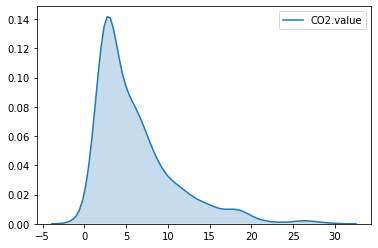

In [52]:
plot_distribution_s(track_df,'CO2.value')

#### Normality of distribution
The Q-Q plot ("quantile-quantile plot")compares the theoretical quantiles expected under a normal distribution to the actual observed values (ordered). When a distribution is normally distributed, you will see a straight line. The more crooked the line is, the farther the distribution departs from normality.

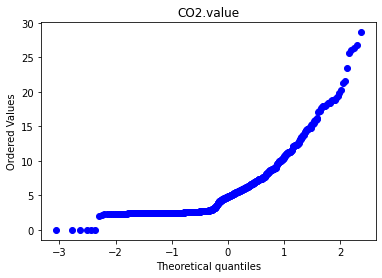

In [29]:
visualize_normality_with_qqplot(track_df, 'CO2.value')

## Compare distributions of measurements of same phenomena
You can compare measurements from OBD with measurements based on GPS. 

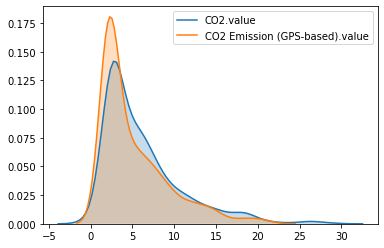

In [51]:
plot_distribution_s(track_df, 'CO2.value', 'CO2 Emission (GPS-based).value' )